## Regression Analysis

We will try applying the regression methods that we have, available to us in the Shogun ML Library.

We start off by importing the necessary libraries.

In [2]:
import pandas as pd
import shogun as sg
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
plt.style.use("dark_background")


In [3]:
def load(path, is_labels=False):
    if path.exists() and path.is_file():
        df = pd.read_csv(path)
        if is_labels:
            df = pd.Series(df['incidence'])
        return df.values

Let's consider Italy. Most probably, what we will compute will remain the same for all the different countries.

In [4]:
country = 'italy'

getting all the datasets which we separated into the training and testing sets using test.py

In [5]:
path = Path.cwd()
country = 'italy'
test_data_path = path.parent / 'data' / 'test' / country
x_train_file_path = test_data_path / 'X_train.csv'
y_train_file_path = test_data_path / 'y_train.csv'
x_test_file_path = test_data_path / 'X_test.csv'
y_test_file_path = test_data_path / 'y_test.csv'

X_train = pd.read_csv(x_train_file_path).values
y_train = pd.read_csv(y_train_file_path).values
X_test = pd.read_csv(x_test_file_path).values
y_test = pd.read_csv(y_test_file_path).values

Using Shogun to apply Linear Ridge Regression.

The first step is creating features and labels from the CSV files.

In [6]:
features_train = sg.create_features(load(x_train_file_path).T)
features_test = sg.create_features(load(x_test_file_path).T)
labels_train = sg.create_labels(load(y_train_file_path, is_labels=True))
labels_test = sg.create_labels(load(y_test_file_path, is_labels=True))

We then create an instance of the Linear Ridge Regression.

In [7]:
lrr = sg.create_machine("LinearRidgeRegression", tau=57, labels=labels_train, use_bias=False)

We also have to set up the cross validation splitting strategy for implementing cross validation.

strategy = sg.create_splitting_strategy("CrossValidationSplitting", labels=labels_train,
                                        num_subsets=5, seed=1)

evaluation_criterium = sg.create_evaluation("MeanSquaredError")
cross_validation = sg.create_machine_evaluation("CrossValidation", machine=lrr,
                                                features=features_train, labels=labels_train,
                                                splitting_strategy=strategy,
                                                evaluation_criterion=evaluation_criterium,
                                                num_runs=10)
result = cross_validation.evaluate()

We can now get the mean and the std deviation

mean = result.get("mean")
print('mean =\t' + str(mean))

stddev = result.get("std_dev")
print('standard deviation =\t' + str(stddev))

Finally we have to train and apply the model.

In [8]:
lrr.train(features_train)
labels_predict = lrr.apply(features_test)
labels_train_predict = lrr.apply(features_train)

We also find the mean squared error of this model as a measure of its accuracy

In [9]:
eval = sg.create_evaluation("MeanSquaredError")
mse = eval.evaluate(labels_predict, labels_test)
print('Mean Squared Error for Linear Ridge Regression is '+str(mse))

Mean Squared Error for Linear Ridge Regression is 7.9536753950385926


Before we plot them, we have to convert all the labels into numpy style arrays.

In [10]:
y_train_predicted = labels_train_predict.get("labels").reshape(labels_train_predict.get("labels").shape[0])
y_test_predicted = labels_predict.get("labels").reshape(labels_predict.get("labels").shape[0])
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

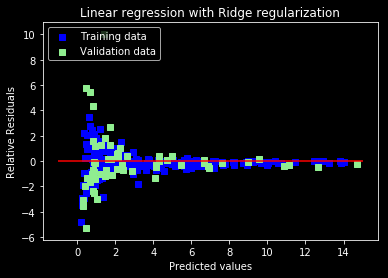

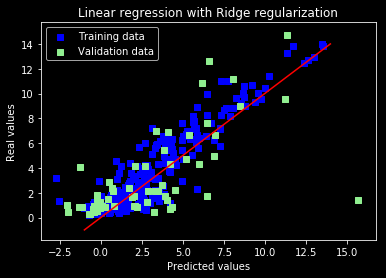

In [11]:
# Plot residuals
plt.scatter(y_train, (y_train_predicted - y_train)/y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, (y_test_predicted - y_test)/y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Relative Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -1, xmax = 15, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_predicted, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_predicted, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([-1, 14], [-1, 14], c = "red")
plt.show()

Now that we have successfully implemented Linear Ridge regression, we start off with implementing Random Forest

We re-initialize the arrays.

In [12]:
X_train = pd.read_csv(x_train_file_path).values
y_train = pd.read_csv(y_train_file_path).values
X_test = pd.read_csv(x_test_file_path).values
y_test = pd.read_csv(y_test_file_path).values

We then have to set up the instance of the Random Forest.

In [13]:
mean_rule = sg.create_combination_rule("MeanRule")
rand_forest = sg.create_machine("RandomForest", labels=labels_train, num_bags=5,
                                seed=1, combination_rule=mean_rule)

Finally we have to train and apply the model.

In [14]:
rand_forest.train(features_train)
model_file_path = Path.cwd() / 'sample_austria_model.json'
sg.serialize(str(model_file_path.absolute()), rand_forest, sg.JsonSerializer())

In [15]:
rand = sg.as_machine(sg.deserialize(str(model_file_path.absolute()), sg.JsonDeserializer()))

In [15]:
labels_predict = rand_forest.apply_regression(features_test)

In [ ]:
labels_train_predict = rand.apply_regression(features_train)


We also find the mean squared error of this model as a measure of its accuracy

In [ ]:
mse = sg.create_evaluation("MeanSquaredError")
rand.put("oob_evaluation_metric", mse)
oob = rand.get("oob_error")
mserror = mse.evaluate(labels_predict, labels_test)
print('Mean Squared Error for Random Forest(Regression) is '+str(mserror))

Before we plot them, we have to convert all the labels into numpy style arrays.

In [ ]:
y_train_predicted = labels_train_predict.get("labels").reshape(labels_train_predict.get("labels").shape[0])
y_test_predicted = labels_predict.get("labels").reshape(labels_predict.get("labels").shape[0])
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

In [ ]:
# Plot residuals
plt.scatter(y_train, (y_train_predicted - y_train)/y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, (y_test_predicted - y_test)/y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Random Forest with Mean Rule")
plt.xlabel("Predicted values")
plt.ylabel("Relative Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -1, xmax = 15, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_predicted, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_predicted, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Random Forest with Mean Rule")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([-1, 14], [-1, 14], c = "red")
plt.show()

Lets have a loop that checks which is better for the different countries, random forest or Linear Ridge.

In [ ]:
from src import config
lrr_mse = {}
rf_mse = {}
alpha = {
    'austria':19.5,
    'belgium':84,
    'germany':37.5,
    'italy':57,
    'netherlands':84
}
config.COUNTRIES

In [ ]:
for country in config.COUNTRIES:
    print('for '+country)
    test_data_path = path.parent / 'data' / 'test' / country
    x_train_file_path = test_data_path / 'X_train.csv'
    y_train_file_path = test_data_path / 'y_train.csv'
    x_test_file_path = test_data_path / 'X_test.csv'
    y_test_file_path = test_data_path / 'y_test.csv'

    X_train = pd.read_csv(x_train_file_path).values
    y_train = pd.read_csv(y_train_file_path).values
    X_test = pd.read_csv(x_test_file_path).values
    y_test = pd.read_csv(y_test_file_path).values

    features_train = sg.create_features(load(x_train_file_path).T)
    features_test = sg.create_features(load(x_test_file_path).T)
    labels_train = sg.create_labels(load(y_train_file_path, is_labels=True))
    labels_test = sg.create_labels(load(y_test_file_path, is_labels=True))

    lrr = sg.create_machine("LinearRidgeRegression", tau=alpha[country], labels=labels_train, use_bias=False)
    strategy = sg.create_splitting_strategy("CrossValidationSplitting", labels=labels_train,
                                        num_subsets=5, seed=1)

    evaluation_criterium = sg.create_evaluation("MeanSquaredError")
    cross_validation = sg.create_machine_evaluation("CrossValidation", machine=lrr,
                                                features=features_train, labels=labels_train,
                                                splitting_strategy=strategy,
                                                evaluation_criterion=evaluation_criterium,
                                                num_runs=10)
    result = cross_validation.evaluate()
    lrr.train(features_train)
    labels_predict = lrr.apply(features_test)
    labels_train_predict = lrr.apply(features_train)
    eval = sg.create_evaluation("MeanSquaredError")
    lrr_mse[country] = eval.evaluate(labels_predict, labels_test)

    y_train_predicted = labels_train_predict.get("labels").reshape(labels_train_predict.get("labels").shape[0])
    y_test_predicted = labels_predict.get("labels").reshape(labels_predict.get("labels").shape[0])
    y_train = y_train.reshape(y_train.shape[0])
    y_test = y_test.reshape(y_test.shape[0])

    pearson_lrr = stats.pearsonr(y_test, y_test_predicted)
    print('\tPearson coefficient using lrr = '+str(pearson_lrr))

    mean_rule = sg.create_combination_rule("MeanRule")
    rand_forest = sg.create_machine("RandomForest", labels=labels_train, num_bags=5,
                                seed=1, combination_rule=mean_rule)

    rand_forest.train(features_train)


    labels_predict = rand_forest.apply_regression(features_test)
    labels_train_predict = rand_forest.apply_regression(features_train)

    mse = sg.create_evaluation("MeanSquaredError")
    rand_forest.put("oob_evaluation_metric", mse)
    oob = rand_forest.get("oob_error")
    rf_mse[country] = mse.evaluate(labels_predict, labels_test)



    # if rf_mse[country] < lrr_mse[country]:
    #     print(country + ':\tRandom Forest')
    # else:
    #     print(country + ':\tLinear Ridge Regression')

    y_train_predicted = labels_train_predict.get("labels").reshape(labels_train_predict.get("labels").shape[0])
    y_test_predicted = labels_predict.get("labels").reshape(labels_predict.get("labels").shape[0])
    y_train = y_train.reshape(y_train.shape[0])
    y_test = y_test.reshape(y_test.shape[0])

    pearson_rf = stats.pearsonr(y_test, y_test_predicted)



    print('\tPearson coefficient using random forest = '+str(pearson_rf))
    print('\tMSE using LRR = '+str(lrr_mse[country]))
    print('\tMSE using random forest = '+str(rf_mse[country]))

    # # Plot residuals
    # plt.scatter(y_train, (y_train_predicted - y_train)/y_train, c = "blue", marker = "s", label = "Training data")
    # plt.scatter(y_test, (y_test_predicted - y_test)/y_test, c = "lightgreen", marker = "s", label = "Validation data")
    # plt.title(country+": Random Forest with Mean Rule")
    # plt.xlabel("Predicted values")
    # plt.ylabel("Relative Residuals")
    # plt.legend(loc = "upper left")
    # plt.hlines(y = 0, xmin = -1, xmax = 15, color = "red")
    # plt.show()
    #
    # # Plot predictions
    # plt.scatter(y_train_predicted, y_train, c = "blue", marker = "s", label = "Training data")
    # plt.scatter(y_test_predicted, y_test, c = "lightgreen", marker = "s", label = "Validation data")
    # plt.title(country+": Random Forest with Mean Rule")
    # plt.xlabel("Predicted values")
    # plt.ylabel("Real values")
    # plt.legend(loc = "upper left")
    # plt.plot([-1, 14], [-1, 14], c = "red")
    # plt.show()

Hence we conclude that Random forest is the better model for all the countries.